# General imports

In [89]:
import argparse
import math
import time
import dill as pickle
from tqdm import tqdm
import numpy as np
import random
import os

import torch
import torch.nn.functional as F
import torch.optim as optim
# from torchtext.data import Field, Dataset, BucketIterator
# from torchtext.datasets import TranslationDataset
from torch.utils.data import Dataset, DataLoader

import transformer.Constants as Constants
from transformer.Models import Transformer
from transformer.Optim import ScheduledOptim
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn


# Data loader

In [114]:
class SineCosDataset(Dataset):
    def __init__(self, num_samples, sequence_length):
        self.num_samples = num_samples
        self.sequence_length = sequence_length
        self.data = self._generate_data()

    def _generate_data(self):
        angles = np.linspace(0, 2 * np.pi, self.sequence_length)
        sine_wave = np.sin(angles)
        cosine_wave = np.cos(angles)
        
        data = []
        for _ in range(self.num_samples):
            # Randomly choose a starting angle for each sample
            start_idx = np.random.randint(0, len(angles) - self.sequence_length + 1)
            sine_seq = sine_wave[start_idx:start_idx + self.sequence_length]
            cosine_seq = cosine_wave[start_idx:start_idx + self.sequence_length]
            # Generate the target (tangent wave)
            tan_seq = np.tan(angles[start_idx:start_idx + self.sequence_length])
            
            # Stack sine and cosine sequences along the feature dimension
            features = np.stack([sine_seq, cosine_seq], axis=-1)
            
            # Convert to tensors and store
            data.append((torch.tensor(features, dtype=torch.float32),
                         torch.tensor(tan_seq, dtype=torch.float32)))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# Call performance

In [55]:
def cal_performance(pred, gold, trg_pad_idx, smoothing=False):
    ''' Apply label smoothing if needed '''

    loss = cal_loss(pred, gold, trg_pad_idx, smoothing=smoothing)

    pred = pred.max(1)[1]
    gold = gold.contiguous().view(-1)
    non_pad_mask = gold.ne(trg_pad_idx)
    n_correct = pred.eq(gold).masked_select(non_pad_mask).sum().item()
    n_word = non_pad_mask.sum().item()

    return loss, n_correct, n_word


In [56]:
def cal_loss(pred, gold, trg_pad_idx, smoothing=False):
    ''' Calculate cross entropy loss, apply label smoothing if needed. '''

    gold = gold.contiguous().view(-1)

    if smoothing:
        eps = 0.1
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        non_pad_mask = gold.ne(trg_pad_idx)
        loss = -(one_hot * log_prb).sum(dim=1)
        loss = loss.masked_select(non_pad_mask).sum()  # average later
    else:
        loss = F.cross_entropy(pred, gold, ignore_index=trg_pad_idx, reduction='sum')
    return loss


# Training Script

In [121]:
def train_epoch(model, training_data, optimizer, opt, device):

    model.train()
    total_loss = 0
    total_samples = 0
    correct_samples = 0

    for sine_cos_seq, tan_seq in tqdm(training_data, desc='Training', leave=False):
        # Move data to the specified device
        sine_cos_seq, tan_seq = sine_cos_seq.to(device), tan_seq.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        pred = model(sine_cos_seq)
        
        # Compute loss
        loss = F.mse_loss(pred.squeeze(), tan_seq)
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        total_loss += loss.item() * sine_cos_seq.size(0)
        total_samples += sine_cos_seq.size(0)
        correct_samples += ((torch.abs(pred.squeeze() - tan_seq) < 0.1).sum().item())
    
    # Compute average loss and accuracy
    avg_loss = total_loss / total_samples
    accuracy = correct_samples / total_samples

    return avg_loss, accuracy


In [59]:
def eval_epoch(model, validation_data, device, opt):
    ''' Epoch operation in evaluation phase '''

    model.eval()
    total_loss, n_word_total, n_word_correct = 0, 0, 0

    desc = '  - (Validation) '
    with torch.no_grad():
        for batch in tqdm(validation_data, mininterval=2, desc=desc, leave=False):

            # prepare data
            src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
            trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

            # forward
            pred = model(src_seq, trg_seq)
            loss, n_correct, n_word = cal_performance(
                pred, gold, opt.trg_pad_idx, smoothing=False)

            # note keeping
            n_word_total += n_word
            n_word_correct += n_correct
            total_loss += loss.item()

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy


In [108]:
def train(model, training_data, validation_data, optimizer, device, opt):
    ''' Start training '''

    # Use tensorboard to plot curves, e.g. perplexity, accuracy, learning rate
    if opt.use_tb:
        print("[Info] Use Tensorboard")
        from torch.utils.tensorboard import SummaryWriter
        tb_writer = SummaryWriter(log_dir=os.path.join(opt.output_dir, 'tensorboard'))

    log_train_file = os.path.join(opt.output_dir, 'train.log')
    log_valid_file = os.path.join(opt.output_dir, 'valid.log')

    print('[Info] Training performance will be written to file: {} and {}'.format(
        log_train_file, log_valid_file))

    with open(log_train_file, 'w') as log_tf, open(log_valid_file, 'w') as log_vf:
        log_tf.write('epoch,loss,ppl,accuracy\n')
        log_vf.write('epoch,loss,ppl,accuracy\n')

    def print_performances(header, ppl, accu, start_time, lr):
        print('  - {header:12} ppl: {ppl: 8.5f}, accuracy: {accu:3.3f} %, lr: {lr:8.5f}, '\
              'elapse: {elapse:3.3f} min'.format(
                  header=f"({header})", ppl=ppl,
                  accu=100*accu, elapse=(time.time()-start_time)/60, lr=lr))

    #valid_accus = []
    valid_losses = []
    for epoch_i in range(opt.epoch):
        print('[ Epoch', epoch_i, ']')

        start = time.time()
        train_loss, train_accu = train_epoch(
            model, training_data, optimizer, opt, device)
        train_ppl = math.exp(min(train_loss, 100))
        # Current learning rate
        lr = optimizer._optimizer.param_groups[0]['lr']
        print_performances('Training', train_ppl, train_accu, start, lr)

        start = time.time()
        valid_loss, valid_accu = eval_epoch(model, validation_data, device, opt)
        valid_ppl = math.exp(min(valid_loss, 100))
        print_performances('Validation', valid_ppl, valid_accu, start, lr)

        valid_losses += [valid_loss]

        checkpoint = {'epoch': epoch_i, 'settings': opt, 'model': model.state_dict()}

        if opt.save_mode == 'all':
            model_name = 'model_accu_{accu:3.3f}.chkpt'.format(accu=100*valid_accu)
            torch.save(checkpoint, model_name)
        elif opt.save_mode == 'best':
            model_name = 'model.chkpt'
            if valid_loss <= min(valid_losses):
                torch.save(checkpoint, os.path.join(opt.output_dir, model_name))
                print('    - [Info] The checkpoint file has been updated.')

        with open(log_train_file, 'a') as log_tf, open(log_valid_file, 'a') as log_vf:
            log_tf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=train_loss,
                ppl=train_ppl, accu=100*train_accu))
            log_vf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=valid_loss,
                ppl=valid_ppl, accu=100*valid_accu))

        if opt.use_tb:
            tb_writer.add_scalars('ppl', {'train': train_ppl, 'val': valid_ppl}, epoch_i)
            tb_writer.add_scalars('accuracy', {'train': train_accu*100, 'val': valid_accu*100}, epoch_i)
            tb_writer.add_scalar('learning_rate', lr, epoch_i)


# Model

In [124]:
class SinCosToTanModel(nn.Module):
    def __init__(self, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048):
        super(SinCosToTanModel, self).__init__()
        self.input_projection = nn.Linear(2, d_model)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward)
        self.output_projection = nn.Linear(d_model, 1)
    
    def forward(self, src, tgt):
        src = self.input_projection(src)
        tgt = self.input_projection(tgt)
        x = self.transformer(src, tgt)
        x = self.output_projection(x)
        return x

In [116]:
#Modified dataloder for wave functions
def prepare_dataloader(opt, device):

    batch_size = opt.batch_size
    sequence_length = opt.sequence_length  # Define the length of the sequence

    # Create datasets
    train_dataset = SineCosDataset(num_samples=opt.num_train_samples, sequence_length=sequence_length)
    val_dataset = SineCosDataset(num_samples=opt.num_val_samples, sequence_length=sequence_length)

    # Create DataLoader instances
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader

In [130]:

#modified main function to run in jupyter notebook
def main():
    ''' 
    Main function to set up and run the model training
    '''

    # Define options directly
    class Opt:
        def __init__(self):
            self.batch_size = 32
            self.sequence_length = 50
            self.num_train_samples = 1000
            self.num_val_samples = 200
            self.epoch = 10
            self.d_model = 512
            self.d_inner_hid = 2048
            self.d_k = 64
            self.d_v = 64
            self.n_head = 8
            self.n_layers = 6
            self.n_warmup_steps = 4000
            self.lr_mul = 2.0
            self.seed = 42
            self.dropout = 0.1
            self.embs_share_weight = True
            self.proj_share_weight = True
            self.scale_emb_or_prj = 'prj'
            self.output_dir = 'output'
            self.use_tb = False
            self.save_mode = 'best'
            self.no_cuda = False
            self.label_smoothing = False

    # Set up options and device
    opt = Opt()
    device = torch.device('cuda' if torch.cuda.is_available() and not opt.no_cuda else 'cpu')

    # Set random seeds for reproducibility
    if opt.seed is not None:
        torch.manual_seed(opt.seed)
        torch.backends.cudnn.benchmark = False
        np.random.seed(opt.seed)
        random.seed(opt.seed)

    # Create output directory if it does not exist
    if not os.path.exists(opt.output_dir):
        os.makedirs(opt.output_dir)

    # Check batch size and warmup steps
    if opt.batch_size < 2048 and opt.n_warmup_steps <= 4000:
        print('[Warning] The warmup steps may be not enough.\n'\
              '(sz_b, warmup) = (2048, 4000) is the official setting.\n'\
              'Using smaller batch w/o longer warmup may cause '\
              'the warmup stage ends with only little data trained.')

    #========= Loading Dataset =========#
    train_loader, val_loader = prepare_dataloader(opt, device)


    # model = SinCosToTanModel()
    # model.to(device)
    # #Initialize optimizer
    # optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09)

    # # Training the model
    # train(model, train_loader, val_loader, optimizer, device, opt)

# Run the main function
# main()


In [131]:

if __name__ == '__main__':
    main()


[Warning] The warmup steps may be not enough.
(sz_b, warmup) = (2048, 4000) is the official setting.
Using smaller batch w/o longer warmup may cause the warmup stage ends with only little data trained.


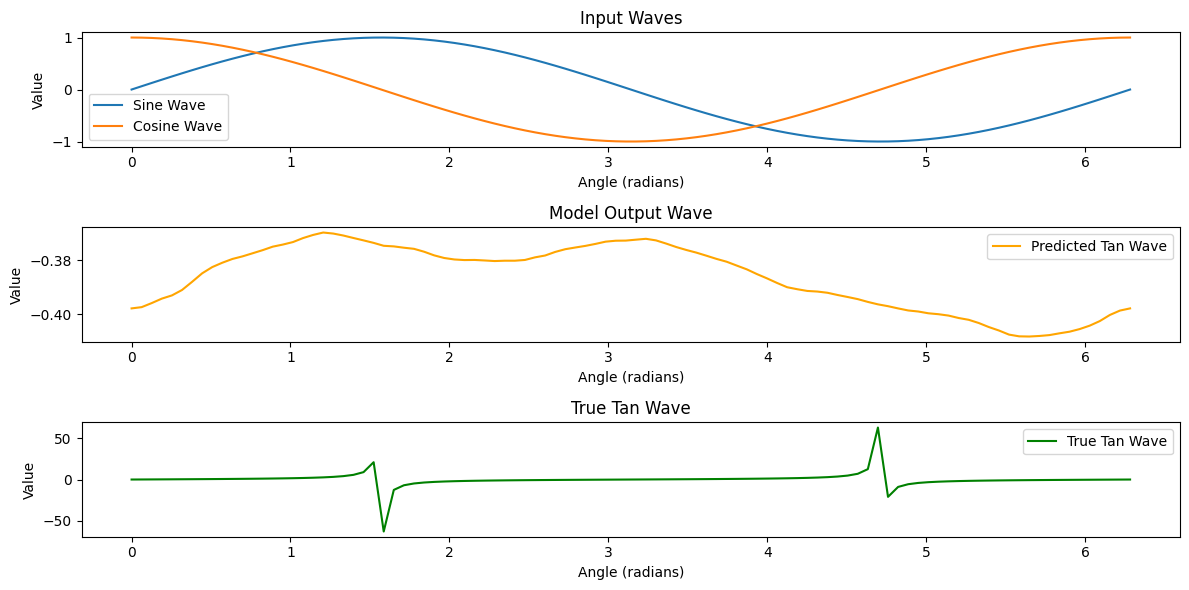

In [95]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

# Define the model
class SinCosToTanModel(nn.Module):
    def __init__(self, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048):
        super(SinCosToTanModel, self).__init__()
        self.input_projection = nn.Linear(2, d_model)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward)
        self.output_projection = nn.Linear(d_model, 1)
    
    def forward(self, src, tgt):
        src = self.input_projection(src)
        tgt = self.input_projection(tgt)
        x = self.transformer(src, tgt)
        x = self.output_projection(x)
        return x

# Initialize the model
model = SinCosToTanModel()

# Generate input data
angles = np.linspace(0, 2 * np.pi, 100)
sine_wave = np.sin(angles)
cos_wave = np.cos(angles)

# Convert to PyTorch tensors
src = torch.tensor(np.stack([sine_wave, cos_wave], axis=1), dtype=torch.float32).unsqueeze(1)  # Add batch dimension
tgt = src  # For simplicity, use the same input as target

# Make predictions
model.eval()
with torch.no_grad():
    output = model(src, tgt).squeeze().numpy()  # Remove batch dimension and convert to numpy array

# Calculate true tangent values for comparison
true_tan_wave = np.tan(angles)

# Plot results
plt.figure(figsize=(12, 6))

# Plot sine and cosine waves
plt.subplot(3, 1, 1)
plt.plot(angles, sine_wave, label='Sine Wave')
plt.plot(angles, cos_wave, label='Cosine Wave')
plt.title('Input Waves')
plt.xlabel('Angle (radians)')
plt.ylabel('Value')
plt.legend()

# Plot predicted tan wave
plt.subplot(3, 1, 2)
plt.plot(angles, output, label='Predicted Tan Wave', color='orange')
plt.title('Model Output Wave')
plt.xlabel('Angle (radians)')
plt.ylabel('Value')
plt.legend()

# Plot true tan wave for comparison
plt.subplot(3, 1, 3)
plt.plot(angles, true_tan_wave, label='True Tan Wave', color='green')
plt.title('True Tan Wave')
plt.xlabel('Angle (radians)')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

# Define the dataset
class SineCosDataset(Dataset):
    def __init__(self, num_samples, sequence_length):
        self.num_samples = num_samples
        self.sequence_length = sequence_length
        self.data = self._generate_data()

    def _generate_data(self):
        angles = np.linspace(0, 2 * np.pi, self.sequence_length)
        sine_wave = np.sin(angles)
        cosine_wave = np.cos(angles)
        
        data = []
        for _ in range(self.num_samples):
            start_idx = np.random.randint(0, len(angles) - self.sequence_length + 1)
            sine_seq = sine_wave[start_idx:start_idx + self.sequence_length]
            cosine_seq = cosine_wave[start_idx:start_idx + self.sequence_length]
            tan_seq = np.tan(angles[start_idx:start_idx + self.sequence_length])
            
            data.append((torch.tensor(sine_seq, dtype=torch.float32),
                         torch.tensor(cosine_seq, dtype=torch.float32),
                         torch.tensor(tan_seq, dtype=torch.float32)))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class SinCosToTanModel(nn.Module):
    def __init__(self, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048):
        super(SinCosToTanModel, self).__init__()
        self.input_projection = nn.Linear(2, d_model)  # 2 features (sine and cosine)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward)
        self.output_projection = nn.Linear(d_model, 1)  # Output is a single value per sequence element
    
    def forward(self, src, tgt):
        src = self.input_projection(src)  # Shape: [batch_size, sequence_length, d_model]
        tgt = self.input_projection(tgt)  # Shape: [batch_size, sequence_length, d_model]

        src = src.permute(1, 0, 2)  # Transformer expects [sequence_length, batch_size, d_model]
        tgt = tgt.permute(1, 0, 2)

        x = self.transformer(src, tgt)
        x = x.permute(1, 0, 2)  # Convert back to [batch_size, sequence_length, d_model]
        x = self.output_projection(x)  # Shape: [batch_size, sequence_length, 1]
        return x


# Training function
def train(model, train_loader, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for sine_seq, cosine_seq, tan_seq in tqdm(train_loader, desc=f'Epoch {epoch+1}', leave=False):
            sine_seq, cosine_seq, tan_seq = sine_seq.to(device), cosine_seq.to(device), tan_seq.to(device)
            
            # Combine sine and cosine sequences to form source and target sequences
            src = torch.stack((sine_seq, cosine_seq), dim=1)  # Shape: [batch_size, sequence_length, 2]
            tgt = torch.stack((sine_seq, cosine_seq), dim=1)  # Shape: [batch_size, sequence_length, 2]

            optimizer.zero_grad()
            
            # Forward pass
            pred = model(src, tgt)
            
            # Compute loss
            pred = pred.squeeze(-1)  # Shape: [batch_size, sequence_length]
            tan_seq = tan_seq.unsqueeze(1)  # Shape: [batch_size, sequence_length]
            loss = F.mse_loss(pred, tan_seq)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * sine_seq.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

# Main script
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyperparameters
    num_samples = 1000
    sequence_length = 50
    batch_size = 32
    d_model = 512
    nhead = 8
    num_encoder_layers = 6
    num_decoder_layers = 6
    dim_feedforward = 2048
    num_epochs = 10
    learning_rate = 1e-4

    # Prepare data
    dataset = SineCosDataset(num_samples=num_samples, sequence_length=sequence_length)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model, optimizer
    model = SinCosToTanModel(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
                             num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train(model, train_loader, optimizer, device, num_epochs=num_epochs)

if __name__ == '__main__':
    main()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x50 and 2x512)